In [136]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [137]:
# setting up preprocessing 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224), # resize the image 
        transforms.ToTensor(), # make tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # [mean of channel 1, ...], [std of channel 1]
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [138]:
data_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'

In [139]:
train_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['val'])

In [146]:
torch.manual_seed(1) # for random number generation 
#num_train_samples = len(train_dataset)
num_train_samples = 30000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)

train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_train_subset = torch.utils.data.Subset(val_dataset, indices[:split])

train_len = len(train_subset)
val_train_len = len(val_train_subset)
train_len, val_train_len

(24000, 6000)

In [147]:
torch.manual_seed(41) # for random number generation 

test_split = 0.5
split = int(val_train_len * test_split)
indices = torch.randperm(val_train_len)

test_subset = torch.utils.data.Subset(val_train_subset, indices[:split])
val_subset = torch.utils.data.Subset(val_train_subset, indices[split:])

test_len = len(test_subset)
val_len = len(val_subset)

train_len, val_len, test_len

(24000, 3000, 3000)

In [148]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_subset,
    batch_size=batch_size,
    shuffle=False
)

In [149]:
class_names = train_dataloader.dataset.dataset.classes
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [151]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

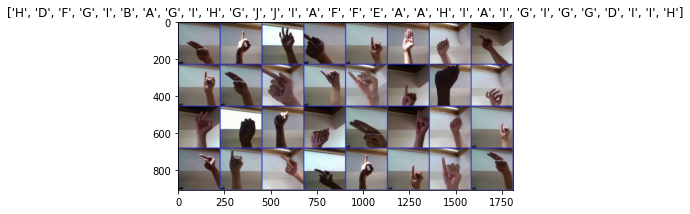

In [152]:
 def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [153]:
# load the resnet model
model_ft = models.resnet50(pretrained=True)

for param in model_ft.parameters(): # freeze pretrained layers
    param.requires_grad = False

# find the input size of the FC layers
in_ftrs = model_ft.fc.in_features
# modify the FC layer to output 29, input is is in_ftrs. this layer is unfrozen 
model_ft.fc = nn.Linear(in_features=in_ftrs, out_features=len(classes))

params_to_update = [] 
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# save model to device
model_ft = model_ft.to(device)

# define loss for multiclass classification
criterion = nn.CrossEntropyLoss()

# define whatever optimizer you want!
optimizer = optim.Adam(params_to_update, lr=0.001)

# decay your learning rate across epochs-- this helps our model converge better and prevents overshooting a local minima
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [154]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        #train 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':
                for inputs, labels in train_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients before the forward pass 
                    optimizer.zero_grad()

                    # forward pass
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'val':
                for inputs, labels in val_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients before the forward pass 
                    optimizer.zero_grad()

                    # forward pass
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects.double() / train_len
            if phase == 'val':
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects.double() / val_len
            

            time_elapsed = time.time() - since # keep track of amount of time per epoch 
            print(f'Time elapsed: {time_elapsed}')
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [156]:
# train the model!
model_ft = train_model(model_ft, criterion, optimizer, train_dataloader, val_dataloader, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
Time elapsed: 203.38720059394836
train Loss: 0.3844 Acc: 0.9192
Time elapsed: 229.45207810401917
val Loss: 0.1723 Acc: 0.9643

Epoch 1/4
----------
Time elapsed: 380.7356176376343
train Loss: 0.1663 Acc: 0.9583
Time elapsed: 399.2144260406494
val Loss: 0.1035 Acc: 0.9750

Epoch 2/4
----------
Time elapsed: 550.7314581871033
train Loss: 0.1172 Acc: 0.9696
Time elapsed: 568.9779100418091
val Loss: 0.1038 Acc: 0.9660

Epoch 3/4
----------
Time elapsed: 720.497234582901
train Loss: 0.0966 Acc: 0.9738
Time elapsed: 739.007807970047
val Loss: 0.0763 Acc: 0.9770

Epoch 4/4
----------
Time elapsed: 890.3898684978485
train Loss: 0.0810 Acc: 0.9777
Time elapsed: 908.8270840644836
val Loss: 0.0579 Acc: 0.9877

Training complete in 15m 9s
Best val Acc: 0.987667


In [157]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'real: {class_names[labels[j]]}. predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

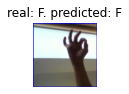

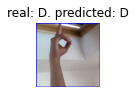

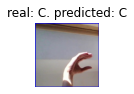

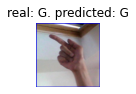

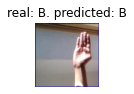

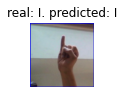

In [158]:
visualize_model(model_ft)

In [159]:
from pathlib import Path
from PIL import Image


test_data_path = Path('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/')


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

In [160]:
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)


def visualize_model2(model):
    columns = 7
    row = round(len(test_dataset) / columns)

    model_ft.eval()

    fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    i, j = 0, 0
    for img, label in test_dataset:
        img = torch.Tensor(img)
        img = img.to(device)
        prediction = model_ft(img[None])

        ax[i][j].imshow(img.cpu().permute(1, 2, 0))
        ax[i][j].set_title(f'real {label}. Pred {class_names[classes[torch.max(prediction, dim=1)[1]]]}')
        ax[i][j].axis('off')
        j += 1
        if j == columns:
            j = 0
            i += 1

    plt.show()

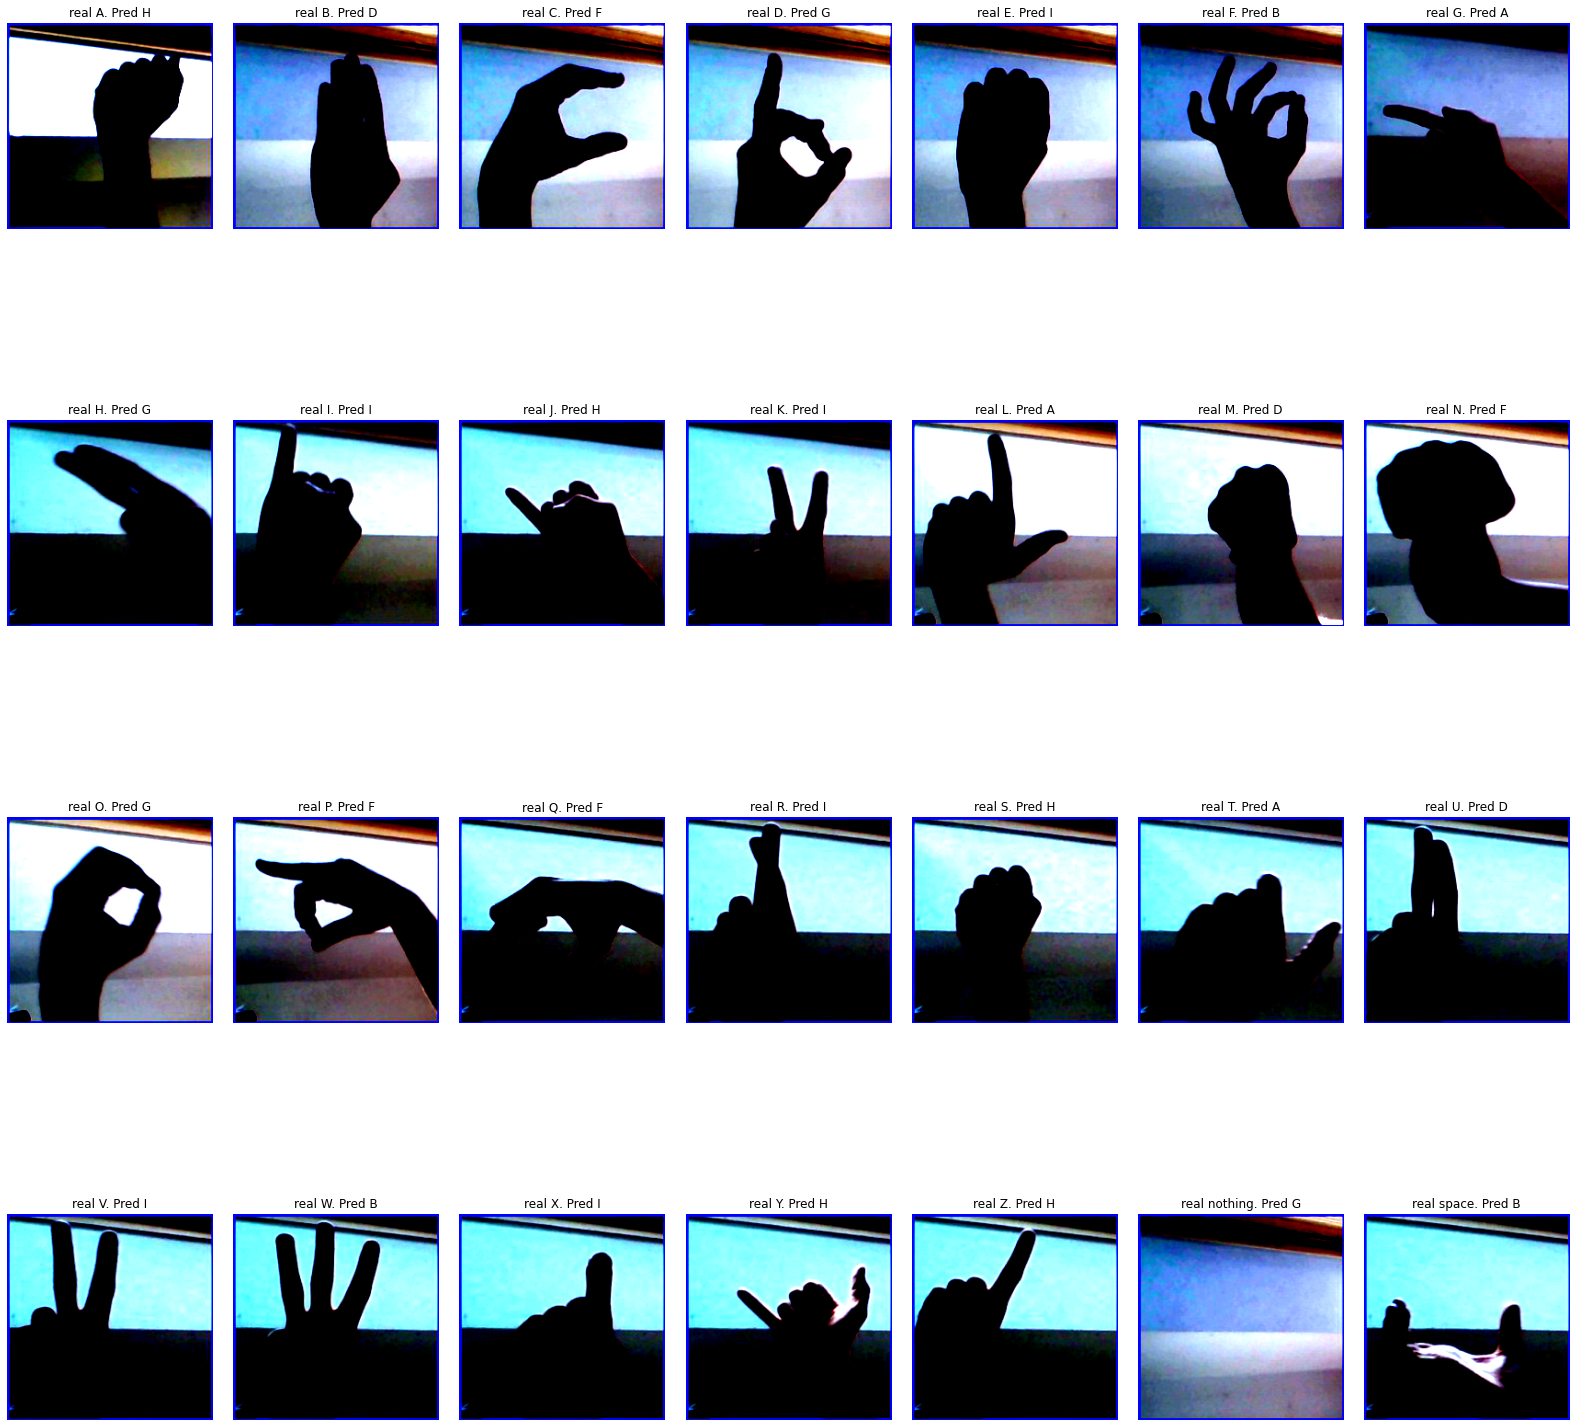

In [161]:
visualize_model2(model_ft)